##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

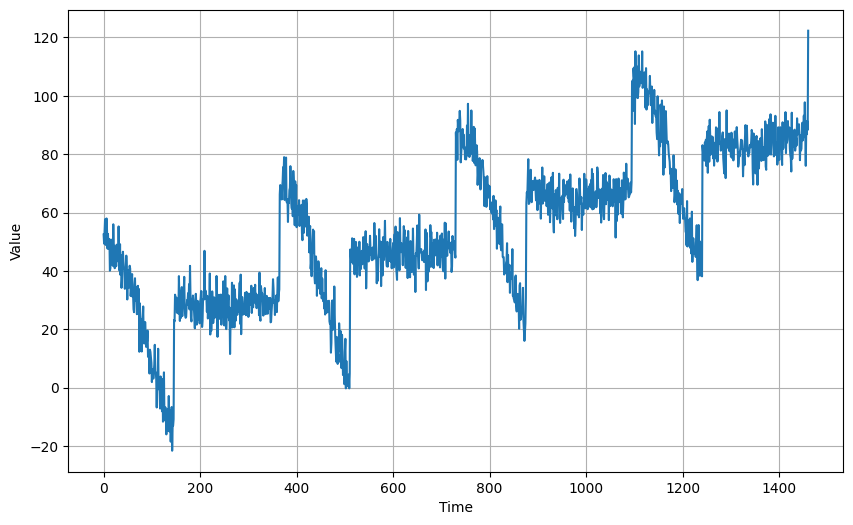

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 81.3178 - mae: 81.8172 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 81.4367 - mae: 81.9360 - learning_rate: 1.1220e-08
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 80.8249 - mae: 81.3240 - learning_rate: 1.2589e-08
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 80.1227 - mae: 80.6218 - learning_rate: 1.4125e-08
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 79.6653 - mae: 80.1646 - learning_rate: 1.5849e-08
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 78.5565 - mae: 79.0558 - learning_rate: 1.7783e-08
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 78.1792 - mae: 78.6784 - learning_rate: 1.9953e-08
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 76.9701 - mae: 77.4694 - learning_rate: 2.2387e-08
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 76.0961 - mae: 76.5955 - learning_rate: 2.5119e-08
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 74.8471 - mae: 75.3465 - learning_rate: 2.8184e-08
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0

(np.float64(1e-08), np.float64(0.0001), np.float64(0.0), np.float64(30.0))

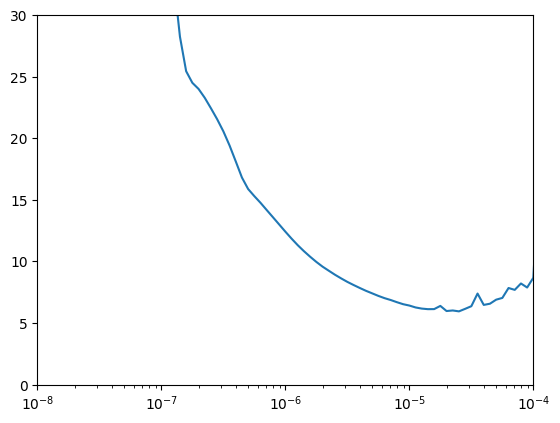

In [7]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown 2s 8ms/step - loss: 31.0331 - mae: 31.5297

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 30.3118 - mae: 30.8083 - val_loss: 24.6772 - val_mae: 25.1745
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.3230 - mae: 15.8166 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15.1136 - mae: 15.6070 - val_loss: 15.6254 - val_mae: 16.1179
Epoch 3/500
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2477 - mae: 9.7353   

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.8933 - mae: 9.3805 - val_loss: 14.3346 - val_mae: 14.8276
Epoch 4/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8999 - mae: 8.3868  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.8038 - mae: 8.2903 - val_loss: 11.2960 - val_mae: 11.7858
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.7904 - mae: 7.2743 - val_loss: 12.0063 - val_mae: 12.4984
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.3117 - mae: 6.7930 - val_loss: 13.6251 - val_mae: 14.1186
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0648 - mae: 6.5448  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.0694 - mae: 6.5494 - val_loss: 10.9305 - val_mae: 11.4209
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0586 - mae: 6.5400 - val_loss: 11.4336 - val_mae: 11.9249
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8527 - mae: 6.3330  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.8568 - mae: 6.3371 - val_loss: 10.0723 - val_mae: 10.5622
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.7329 - mae: 6.2130 - val_loss: 10.2753 - val_mae: 10.7649
Epoch 11/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6709 - mae: 6.1504  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.6626 - mae: 6.1421 - val_loss: 10.0111 - val_mae: 10.5009
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5372 - mae: 6.0173 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.5395 - mae: 6.0196 - val_loss: 9.4551 - val_mae: 9.9434
Epoch 13/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.4887 - mae: 5.9667 - val_loss: 9.7263 - val_mae: 10.2161
Epoch 14/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4869 - mae: 5.9644  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.4784 - mae: 5.9559 - val_loss: 9.0897 - val_mae: 9.5787
Epoch 15/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3212 - mae: 5.8005  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.3235 - mae: 5.8028 - val_loss: 8.9766 - val_mae: 9.4658
Epoch 16/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.2720 - mae: 5.7515 - val_loss: 9.0754 - val_mae: 9.5657
Epoch 17/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2948 - mae: 5.7739 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2892 - mae: 5.7682 - val_loss: 8.6124 - val_mae: 9.0994
Epoch 18/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.2145 - mae: 5.6927 - val_loss: 8.7608 - val_mae: 9.2494
Epoch 19/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1103 - mae: 5.5877  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.1112 - mae: 5.5886 - val_loss: 8.4070 - val_mae: 8.8928
Epoch 20/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0248 - mae: 5.5019 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0295 - mae: 5.5067 - val_loss: 8.3431 - val_mae: 8.8277
Epoch 21/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0641 - mae: 5.5413  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0597 - mae: 5.5369 - val_loss: 7.9831 - val_mae: 8.4702
Epoch 22/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.0136 - mae: 5.4914 - val_loss: 8.0458 - val_mae: 8.5305
Epoch 23/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9584 - mae: 5.4366 - val_loss: 8.1814 - val_mae: 8.6650
Epoch 24/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9009 - mae: 5.3788  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.9040 - mae: 5.3820 - val_loss: 7.7557 - val_mae: 8.2423
Epoch 25/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.9397 - mae: 5.4174 - val_loss: 8.1361 - val_mae: 8.6202
Epoch 26/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9163 - mae: 5.3943 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9089 - mae: 5.3869 - val_loss: 7.5722 - val_mae: 8.0582
Epoch 27/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8964 - mae: 5.3752 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.8928 - mae: 5.3716 - val_loss: 7.4193 - val_mae: 7.9035
Epoch 28/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.8430 - mae: 5.3211 - val_loss: 7.5430 - val_mae: 8.0281
Epoch 29/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.7326 - mae: 5.2101 - val_loss: 7.4525 - val_mae: 7.9376
Epoch 30/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.8461 - mae: 5.3235 - val_loss: 7.8073 - val_mae: 8.2905
Epoch 31/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.8388 - mae: 5.3171 - val_loss: 7.4483 - val_mae: 7.9325
Epoch 32/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8000 - mae: 5.2786  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7963 - mae: 5.2749 - val_loss: 7.3486 - val_mae: 7.8328
Epoch 33/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7873 - mae: 5.2663 - val_loss: 7.6233 - val_mae: 8.1064
Epoch 34/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7632 - mae: 5.2407  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.7627 - mae: 5.2402 - val_loss: 7.2614 - val_mae: 7.7448
Epoch 35/500
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7518 - mae: 5.2303 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.7524 - mae: 5.2306 - val_loss: 6.9768 - val_mae: 7.4610
Epoch 36/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.7566 - mae: 5.2342 - val_loss: 7.3015 - val_mae: 7.7840
Epoch 37/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.6122 - mae: 5.0906 - val_loss: 7.1427 - val_mae: 7.6259
Epoch 38/500
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6024 - mae: 5.0812 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.6252 - mae: 5.1039 - val_loss: 6.9604 - val_mae: 7.4445
Epoch 39/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6419 - mae: 5.1209 - val_loss: 7.0308 - val_mae: 7.5145
Epoch 40/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6915 - mae: 5.1700  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.6879 - mae: 5.1664 - val_loss: 6.9146 - val_mae: 7.3982
Epoch 41/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.6181 - mae: 5.0963 - val_loss: 7.0795 - val_mae: 7.5617
Epoch 42/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6032 - mae: 5.0804  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.6118 - mae: 5.0891 - val_loss: 6.6756 - val_mae: 7.1588
Epoch 43/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.6569 - mae: 5.1342 - val_loss: 6.9400 - val_mae: 7.4234
Epoch 44/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.6336 - mae: 5.1116 - val_loss: 6.9580 - val_mae: 7.4396
Epoch 45/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6334 - mae: 5.1110 - val_loss: 7.0028 - val_mae: 7.4843
Epoch 46/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.6093 - mae: 5.0866 - val_loss: 6.9961 - val_mae: 7.4779
Epoch 47/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5698 - mae: 5.0471  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5759 - mae: 5.0531 - val_loss: 6.6200 - val_mae: 7.1032
Epoch 48/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5465 - mae: 5.0238 - val_loss: 6.7065 - val_mae: 7.1896
Epoch 49/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5892 - mae: 5.0659 - val_loss: 6.8548 - val_mae: 7.3366
Epoch 50/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.5473 - mae: 5.0239 - val_loss: 6.9562 - val_mae: 7.4379
Epoch 51/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.5538 - mae: 5.0308 - val_loss: 6.9664 - val_mae: 7.4483
Epoch 52/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 4.5895 - mae: 5.0655

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.5522 - mae: 5.0278 - val_loss: 6.4214 - val_mae: 6.9045
Epoch 53/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.6363 - mae: 5.1130 - val_loss: 6.7285 - val_mae: 7.2110
Epoch 54/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5601 - mae: 5.0373 - val_loss: 6.7901 - val_mae: 7.2720
Epoch 55/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.5459 - mae: 5.0229 - val_loss: 6.8107 - val_mae: 7.2927
Epoch 56/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5527 - mae: 5.0287 - val_loss: 6.6338 - val_mae: 7.1154
Epoch 57/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.5086 - mae: 4.9854 - val_loss: 6.7689 - val_mae: 7.2512
Epoch 58/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5333 - mae: 5.0109 - val_loss: 6.7563 - val_mae: 7.2387
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.4920 - mae: 4.9691 - val_loss: 6.7891 - val_mae: 7.2717
Epoch 60/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.5001 - mae: 4.97

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.5084 - mae: 4.9850 - val_loss: 6.1991 - val_mae: 6.6822
Epoch 68/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4915 - mae: 4.9682 - val_loss: 6.3972 - val_mae: 6.8776
Epoch 69/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.5228 - mae: 5.0003 - val_loss: 6.5931 - val_mae: 7.0753
Epoch 70/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.4760 - mae: 4.9523 - val_loss: 6.6817 - val_mae: 7.1649
Epoch 71/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.4351 - mae: 4.9116 - val_loss: 6.4537 - val_mae: 6.9338
Epoch 72/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3941 - mae: 4.8712 - val_loss: 6.6129 - val_mae: 7.0955
Epoch 73/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4694 - mae: 4.9461 - val_loss: 6.5398 - val_mae: 7.0219
Epoch 74/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.4563 - mae: 4.9332 - val_loss: 6.5963 - val_mae: 7.0783
Epoch 75/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3833 - mae: 4.86

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.3481 - mae: 4.8218 - val_loss: 6.1799 - val_mae: 6.6607
Epoch 96/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3213 - mae: 4.7951 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3217 - mae: 4.7955 - val_loss: 6.1728 - val_mae: 6.6537
Epoch 97/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.3294 - mae: 4.8032 - val_loss: 6.3460 - val_mae: 6.8273
Epoch 98/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3461 - mae: 4.8195 - val_loss: 6.4270 - val_mae: 6.9088
Epoch 99/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.3279 - mae: 4.8016 - val_loss: 6.3371 - val_mae: 6.8183
Epoch 100/500
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3608 - mae: 4.8342 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3529 - mae: 4.8264 - val_loss: 6.1097 - val_mae: 6.5905
Epoch 101/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3516 - mae: 4.8263  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.3518 - mae: 4.8265 - val_loss: 5.9518 - val_mae: 6.4345
Epoch 102/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3327 - mae: 4.8075  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3322 - mae: 4.8069 - val_loss: 5.9171 - val_mae: 6.4000
Epoch 103/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3115 - mae: 4.7865 - val_loss: 6.0166 - val_mae: 6.4986
Epoch 104/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2757 - mae: 4.7500 - val_loss: 6.3510 - val_mae: 6.8325
Epoch 105/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2998 - mae: 4.7733 - val_loss: 6.1218 - val_mae: 6.6029
Epoch 106/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3435 - mae: 4.8177 - val_loss: 5.9848 - val_mae: 6.4673
Epoch 107/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3289 - mae: 4.8040 - val_loss: 6.0875 - val_mae: 6.5685
Epoch 108/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2904 - mae: 4.7638 - val_loss: 6.4088 - val_mae: 6.8906
Epoch 109/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.2993 - mae: 4.7738 - val_loss: 6.4919 - val_mae: 6.9738
Epoch 110/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3026 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.2649 - mae: 4.7381 - val_loss: 5.9007 - val_mae: 6.3826
Epoch 120/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2958 - mae: 4.7700  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.2928 - mae: 4.7670 - val_loss: 5.8126 - val_mae: 6.2944
Epoch 121/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2886 - mae: 4.7643 - val_loss: 5.8660 - val_mae: 6.3480
Epoch 122/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2842 - mae: 4.7577 - val_loss: 5.9524 - val_mae: 6.4339
Epoch 123/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2556 - mae: 4.7298 - val_loss: 5.9576 - val_mae: 6.4394
Epoch 124/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2779 - mae: 4.7520 - val_loss: 6.0285 - val_mae: 6.5101
Epoch 125/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2497 - mae: 4.7230 - val_loss: 6.1723 - val_mae: 6.6546
Epoch 126/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2733 - mae: 4.7464 - val_loss: 6.0310 - val_mae: 6.5125
Epoch 127/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.2711 - mae: 4.7443 - val_loss: 6.0644 - val_mae: 6.5466
Epoch 128/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.2498 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.2743 - mae: 4.7486 - val_loss: 5.7634 - val_mae: 6.2440
Epoch 135/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.2715 - mae: 4.7447 - val_loss: 5.8812 - val_mae: 6.3631
Epoch 136/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.2428 - mae: 4.7161 - val_loss: 6.2114 - val_mae: 6.6931
Epoch 137/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.2511 - mae: 4.7243 - val_loss: 6.0545 - val_mae: 6.5365
Epoch 138/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2689 - mae: 4.7434 - val_loss: 6.0023 - val_mae: 6.4853
Epoch 139/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2166 - mae: 4.6902 - val_loss: 6.4714 - val_mae: 6.9526
Epoch 140/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2669 - mae: 4.7412 - val_loss: 5.9854 - val_mae: 6.4672
Epoch 141/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.2876 - mae: 4.7621 - val_loss: 6.1877 - val_mae: 6.6694
Epoch 142/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2933 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.2398 - mae: 4.7134 - val_loss: 5.7451 - val_mae: 6.2262
Epoch 157/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2130 - mae: 4.6858 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2135 - mae: 4.6863 - val_loss: 5.7305 - val_mae: 6.2112
Epoch 158/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.2217 - mae: 4.6958 - val_loss: 5.7739 - val_mae: 6.2556
Epoch 159/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2023 - mae: 4.6757 - val_loss: 5.7850 - val_mae: 6.2665
Epoch 160/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2350 - mae: 4.7070 - val_loss: 6.0294 - val_mae: 6.5119
Epoch 161/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2361 - mae: 4.7092 - val_loss: 6.0693 - val_mae: 6.5508
Epoch 162/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2364 - mae: 4.7102  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2346 - mae: 4.7083 - val_loss: 5.6964 - val_mae: 6.1772
Epoch 163/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1849 - mae: 4.6572 - val_loss: 5.7581 - val_mae: 6.2394
Epoch 164/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1826 - mae: 4.6559 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.1851 - mae: 4.6583 - val_loss: 5.6655 - val_mae: 6.1459
Epoch 165/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.2309 - mae: 4.7042 - val_loss: 5.7529 - val_mae: 6.2343
Epoch 166/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 4.2231 - mae: 4.6959 - val_loss: 5.8530 - val_mae: 6.3347
Epoch 167/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.1735 - mae: 4.6461 - val_loss: 5.8205 - val_mae: 6.3019
Epoch 168/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1958 - mae: 4.6691 - val_loss: 5.8597 - val_mae: 6.3415
Epoch 169/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1854 - mae: 4.6589 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.1869 - mae: 4.6604 - val_loss: 5.5996 - val_mae: 6.0794
Epoch 170/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.2139 - mae: 4.6879 - val_loss: 5.7647 - val_mae: 6.2459
Epoch 171/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2099 - mae: 4.6832 - val_loss: 5.8749 - val_mae: 6.3568
Epoch 172/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.2058 - mae: 4.6781 - val_loss: 5.7776 - val_mae: 6.2589
Epoch 173/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1777 - mae: 4.6501 - val_loss: 6.2877 - val_mae: 6.7678
Epoch 174/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.2702 - mae: 4.7444 - val_loss: 5.9978 - val_mae: 6.4795
Epoch 175/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2132 - mae: 4.6850 - val_loss: 5.9958 - val_mae: 6.4783
Epoch 176/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1722 - mae: 4.6455 - val_loss: 5.7707 - val_mae: 6.2518
Epoch 177/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2126 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.1868 - mae: 4.6609 - val_loss: 5.5071 - val_mae: 5.9876
Epoch 210/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1843 - mae: 4.6581 - val_loss: 5.5146 - val_mae: 5.9948
Epoch 211/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1563 - mae: 4.6302 - val_loss: 5.6460 - val_mae: 6.1265
Epoch 212/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1451 - mae: 4.6176 - val_loss: 5.5661 - val_mae: 6.0462
Epoch 213/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.1461 - mae: 4.6192 - val_loss: 5.6785 - val_mae: 6.1594
Epoch 214/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1249 - mae: 4.5976  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1343 - mae: 4.6070 - val_loss: 5.5014 - val_mae: 5.9815
Epoch 215/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1638 - mae: 4.6366 - val_loss: 5.7243 - val_mae: 6.2048
Epoch 216/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.1581 - mae: 4.6300 - val_loss: 5.7408 - val_mae: 6.2227
Epoch 217/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1515 - mae: 4.6247 - val_loss: 5.7239 - val_mae: 6.2063
Epoch 218/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1274 - mae: 4.6001 - val_loss: 5.6695 - val_mae: 6.1500
Epoch 219/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1219 - mae: 4.5939 - val_loss: 5.7489 - val_mae: 6.2316
Epoch 220/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1479 - mae: 4.6204 - val_loss: 5.8180 - val_mae: 6.3002
Epoch 221/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1217 - mae: 4.5941 - val_loss: 5.6031 - val_mae: 6.0830
Epoch 222/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1105 - ma

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1141 - mae: 4.5868 - val_loss: 5.4729 - val_mae: 5.9530
Epoch 223/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1840 - mae: 4.6573 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1815 - mae: 4.6547 - val_loss: 5.2642 - val_mae: 5.7461
Epoch 224/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.2158 - mae: 4.6910 - val_loss: 5.4365 - val_mae: 5.9163
Epoch 225/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1615 - mae: 4.6351 - val_loss: 5.4587 - val_mae: 5.9383
Epoch 226/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1974 - mae: 4.6708 - val_loss: 5.8800 - val_mae: 6.3627
Epoch 227/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1628 - mae: 4.6353 - val_loss: 5.8590 - val_mae: 6.3414
Epoch 228/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4.1419 - mae: 4.6149 - val_loss: 5.8931 - val_mae: 6.3762
Epoch 229/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1540 - mae: 4.6258 - val_loss: 5.5573 - val_mae: 6.0370
Epoch 230/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.1360 - mae: 4.6086 - val_loss: 5.8109 - val_mae: 6.2937
Epoch 231/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.1695 - m

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1339 - mae: 4.6064 - val_loss: 5.2553 - val_mae: 5.7368
Epoch 254/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1574 - mae: 4.6307 - val_loss: 5.4187 - val_mae: 5.8984
Epoch 255/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1056 - mae: 4.5782 - val_loss: 5.4996 - val_mae: 5.9793
Epoch 256/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1124 - mae: 4.5846 - val_loss: 5.8892 - val_mae: 6.3707
Epoch 257/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1514 - mae: 4.6242 - val_loss: 6.1060 - val_mae: 6.5855
Epoch 258/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1633 - mae: 4.6374 - val_loss: 5.6231 - val_mae: 6.1039
Epoch 259/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1666 - mae: 4.6406 - val_loss: 5.3939 - val_mae: 5.8736
Epoch 260/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.1223 - mae: 4.5965 - val_loss: 5.3588 - val_mae: 5.8385
Epoch 261/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 4.1367 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.1446 - mae: 4.6171 - val_loss: 5.2440 - val_mae: 5.7241
Epoch 283/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1665 - mae: 4.6393  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.1646 - mae: 4.6374 - val_loss: 5.2013 - val_mae: 5.6816
Epoch 284/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1415 - mae: 4.6144 - val_loss: 5.4419 - val_mae: 5.9212
Epoch 285/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1073 - mae: 4.5796 - val_loss: 5.5698 - val_mae: 6.0504
Epoch 286/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.1106 - mae: 4.5829 - val_loss: 5.3367 - val_mae: 5.8163
Epoch 287/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.0969 - mae: 4.5701 - val_loss: 5.5115 - val_mae: 5.9912
Epoch 288/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0787 - mae: 4.5499 - val_loss: 5.5715 - val_mae: 6.0540
Epoch 289/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.1129 - mae: 4.5858 - val_loss: 5.2739 - val_mae: 5.7544
Epoch 290/500
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1400 - mae: 4.6128 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.1385 - mae: 4.6114 - val_loss: 5.1992 - val_mae: 5.6807
Epoch 291/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 4.1743 - mae: 4.6493 - val_loss: 5.4436 - val_mae: 5.9231
Epoch 292/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.1132 - mae: 4.5857 - val_loss: 5.6951 - val_mae: 6.1778
Epoch 293/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0711 - mae: 4.5426 - val_loss: 5.5452 - val_mae: 6.0269
Epoch 294/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1259 - mae: 4.5978 - val_loss: 5.7678 - val_mae: 6.2492
Epoch 295/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1012 - mae: 4.5727 - val_loss: 5.4218 - val_mae: 5.9009
Epoch 296/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0818 - mae: 4.5543 - val_loss: 5.5707 - val_mae: 6.0519
Epoch 297/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1129 - mae: 4.5852 - val_loss: 5.7752 - val_mae: 6.2576
Epoch 298/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.0801 - 

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


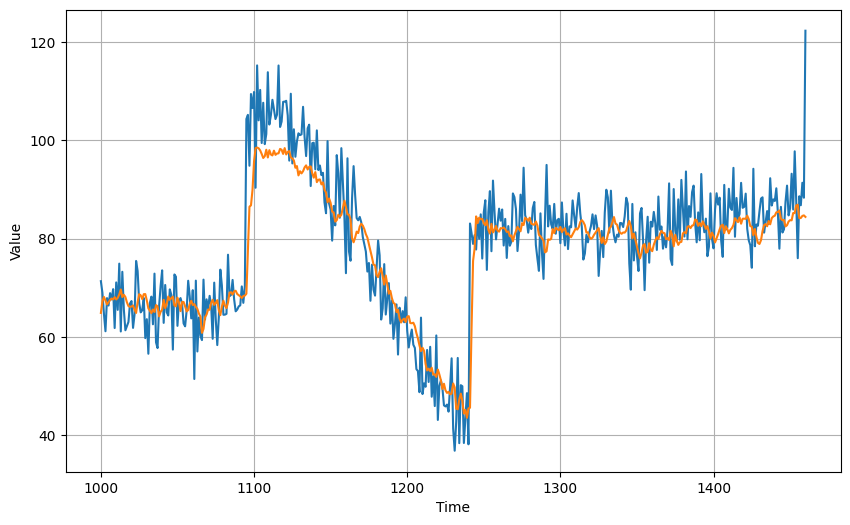

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mae(x_valid, rnn_forecast).numpy()

np.float32(5.164115)

## Fully Convolutional Forecasting

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,  # Сколько будет прыжок - корткие тренды и долгосрочные
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - loss: 40.4178 - mae: 40.9168 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39.6838 - mae: 40.1827 - learning_rate: 1.0798e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.5244 - mae: 39.0231 - learning_rate: 1.1659e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 38.6554 - mae: 39.1541 - learning_rate: 1.2589e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 37.4953 - mae: 37.9939 - learning_rate: 1.3594e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35.6665 - mae: 36.1651 - learning_rate: 1.4678e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.3236 - mae: 33.8221 - learning_rate: 1.5849e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.1845 - mae: 29.6825 - learning_rate: 1.7113e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.7156 - mae: 25.2128 - learning_rate: 1.8478e-04
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 

(np.float64(0.0001), np.float64(0.1), np.float64(0.0), np.float64(30.0))

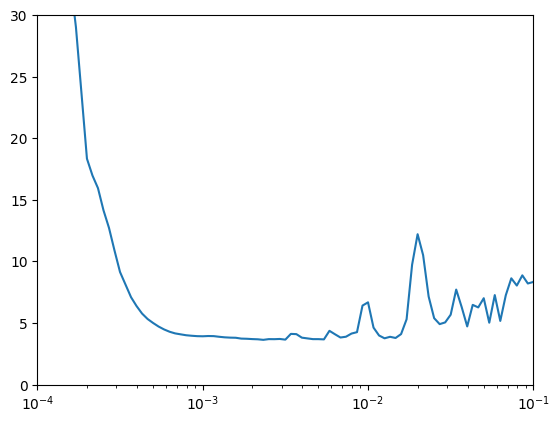

In [14]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown 6s 174ms/step - loss: 42.1563 - mae: 42.6554

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - loss: 42.1446 - mae: 42.6436 - val_loss: 77.8333 - val_mae: 78.3333
Epoch 2/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 42.3763 - mae: 42.8754

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 41.3572 - mae: 41.8564 - val_loss: 76.6706 - val_mae: 77.1706
Epoch 3/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 37.8805 - mae: 38.3794

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 40.1993 - mae: 40.6985 - val_loss: 75.0923 - val_mae: 75.5923
Epoch 4/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 40.4945 - mae: 40.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 40.3282 - mae: 40.8273 - val_loss: 72.7509 - val_mae: 73.2509
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.9496 - mae: 39.4482

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 38.8632 - mae: 39.3617 - val_loss: 68.7544 - val_mae: 69.2544
Epoch 6/500
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.4220 - mae: 36.9202 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 36.0294 - mae: 36.5278 - val_loss: 61.1060 - val_mae: 61.6060
Epoch 7/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 32.3536 - mae: 32.8517

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 31.2330 - mae: 31.7312 - val_loss: 47.4533 - val_mae: 47.9533
Epoch 8/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 24.2678 - mae: 24.7654

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 22.7126 - mae: 23.2093 - val_loss: 26.9771 - val_mae: 27.4699
Epoch 9/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 16.6614 - mae: 17.1525

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 16.4068 - mae: 16.8987 - val_loss: 26.3207 - val_mae: 26.8165
Epoch 10/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 17.2218 - mae: 17.7165

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 16.0471 - mae: 16.5404 - val_loss: 20.8578 - val_mae: 21.3475
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.2890 - mae: 13.7767  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 13.2576 - mae: 13.7453 - val_loss: 18.6293 - val_mae: 19.1186
Epoch 12/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 12.4417 - mae: 12.9286

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.7917 - mae: 12.2787 - val_loss: 15.6650 - val_mae: 16.1540
Epoch 13/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - loss: 10.6075 - mae: 11.0944

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 10.3392 - mae: 10.8258 - val_loss: 14.0827 - val_mae: 14.5713
Epoch 14/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 9.5559 - mae: 10.0413

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1970 - mae: 9.6820 - val_loss: 11.3685 - val_mae: 11.8550
Epoch 15/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - loss: 8.1277 - mae: 8.6118

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.8821 - mae: 8.3653 - val_loss: 9.6035 - val_mae: 10.0872
Epoch 16/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 6.8544 - mae: 7.3361

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.8713 - mae: 7.3534 - val_loss: 8.2603 - val_mae: 8.7438
Epoch 17/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 6.4322 - mae: 6.9125

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.3308 - mae: 6.8108 - val_loss: 7.1233 - val_mae: 7.6048
Epoch 18/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 5.9101 - mae: 6.3895

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.7647 - mae: 6.2440 - val_loss: 6.2595 - val_mae: 6.7391
Epoch 19/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3085 - mae: 5.7875  

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3060 - mae: 5.7850 - val_loss: 5.7301 - val_mae: 6.2090
Epoch 20/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 5.2294 - mae: 5.7082

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.0872 - mae: 5.5658 - val_loss: 5.3952 - val_mae: 5.8737
Epoch 21/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - loss: 4.9448 - mae: 5.4228

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.8555 - mae: 5.3329 - val_loss: 5.1396 - val_mae: 5.6180
Epoch 22/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - loss: 4.7861 - mae: 5.2636

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.6890 - mae: 5.1657 - val_loss: 4.9606 - val_mae: 5.4389
Epoch 23/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 4.6243 - mae: 5.1010

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.5775 - mae: 5.0543 - val_loss: 4.7399 - val_mae: 5.2191
Epoch 24/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 4.4539 - mae: 4.9300

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.4386 - mae: 4.9154 - val_loss: 4.6223 - val_mae: 5.1005
Epoch 25/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 4.3365 - mae: 4.8136

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.3593 - mae: 4.8362 - val_loss: 4.4990 - val_mae: 4.9763
Epoch 26/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3175 - mae: 4.7940  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 4.3168 - mae: 4.7933 - val_loss: 4.4673 - val_mae: 4.9449
Epoch 27/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3030 - mae: 4.7798  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.2972 - mae: 4.7739 - val_loss: 4.4182 - val_mae: 4.8949
Epoch 28/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - loss: 4.2109 - mae: 4.6872

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.2446 - mae: 4.7208 - val_loss: 4.3809 - val_mae: 4.8571
Epoch 29/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.2153 - mae: 4.6908 - val_loss: 4.3819 - val_mae: 4.8580
Epoch 30/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - loss: 4.2110 - mae: 4.6869

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.2026 - mae: 4.6783 - val_loss: 4.3473 - val_mae: 4.8230
Epoch 31/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 4.1607 - mae: 4.6365

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.1796 - mae: 4.6553 - val_loss: 4.3372 - val_mae: 4.8129
Epoch 32/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 4.1615 - mae: 4.6368 - val_loss: 4.3572 - val_mae: 4.8328
Epoch 33/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 4.1337 - mae: 4.6091

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.1355 - mae: 4.6103 - val_loss: 4.3205 - val_mae: 4.7961
Epoch 34/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - loss: 4.0825 - mae: 4.5565

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.1143 - mae: 4.5885 - val_loss: 4.3139 - val_mae: 4.7899
Epoch 35/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0871 - mae: 4.5615 - val_loss: 4.3183 - val_mae: 4.7943
Epoch 36/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 3.9956 - mae: 4.4702

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.0710 - mae: 4.5449 - val_loss: 4.3011 - val_mae: 4.7766
Epoch 37/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.0676 - mae: 4.5417 - val_loss: 4.3365 - val_mae: 4.8112
Epoch 38/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0441 - mae: 4.5181 - val_loss: 4.3186 - val_mae: 4.7937
Epoch 39/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 4.0370 - mae: 4.5109

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.0317 - mae: 4.5056 - val_loss: 4.2821 - val_mae: 4.7576
Epoch 40/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0175 - mae: 4.4915 - val_loss: 4.3358 - val_mae: 4.8107
Epoch 41/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.9800 - mae: 4.4543 - val_loss: 4.3028 - val_mae: 4.7779
Epoch 42/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9665 - mae: 4.4406 - val_loss: 4.2924 - val_mae: 4.7674
Epoch 43/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9533 - mae: 4.4266 - val_loss: 4.2874 - val_mae: 4.7621
Epoch 44/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9447 - mae: 4.4180 - val_loss: 4.3035 - val_mae: 4.7787
Epoch 45/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.9210 - mae: 4.3947 - val_loss: 4.2966 - val_mae: 4.7715
Epoch 46/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9159 - mae: 4.3890 - val_loss: 4.3243 - val_mae: 4.7989
Epoch 47/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.9112 - mae: 4.38

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8973 - mae: 4.3702 - val_loss: 4.2814 - val_mae: 4.7561
Epoch 49/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.9034 - mae: 4.3759 - val_loss: 4.3550 - val_mae: 4.8303
Epoch 50/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 3.8896 - mae: 4.3635

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.8758 - mae: 4.3484 - val_loss: 4.2560 - val_mae: 4.7315
Epoch 51/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 3.8824 - mae: 4.3548 - val_loss: 4.2871 - val_mae: 4.7623
Epoch 52/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.8579 - mae: 4.3304 - val_loss: 4.3133 - val_mae: 4.7884
Epoch 53/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 3.8556 - mae: 4.3275 - val_loss: 4.2630 - val_mae: 4.7383
Epoch 54/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.8400 - mae: 4.3108 - val_loss: 4.2866 - val_mae: 4.7616
Epoch 55/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.8287 - mae: 4.2998 - val_loss: 4.3024 - val_mae: 4.7772
Epoch 56/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 3.8115 - mae: 4.2820

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.8098 - mae: 4.2803 - val_loss: 4.2422 - val_mae: 4.7183
Epoch 57/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.8024 - mae: 4.2729 - val_loss: 4.3143 - val_mae: 4.7893
Epoch 58/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.8039 - mae: 4.2737 - val_loss: 4.2698 - val_mae: 4.7453
Epoch 59/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7897 - mae: 4.2594 - val_loss: 4.3488 - val_mae: 4.8244
Epoch 60/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7890 - mae: 4.2590 - val_loss: 4.2653 - val_mae: 4.7410
Epoch 61/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.7673 - mae: 4.2367 - val_loss: 4.2611 - val_mae: 4.7363
Epoch 62/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.7677 - mae: 4.2363 - val_loss: 4.2651 - val_mae: 4.7406
Epoch 63/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.7378 - mae: 4.2052 - val_loss: 4.2810 - val_mae: 4.7561
Epoch 64/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7601 - mae: 4.22

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.6877 - mae: 4.1533 - val_loss: 4.2307 - val_mae: 4.7055
Epoch 72/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.6786 - mae: 4.1449 - val_loss: 4.3261 - val_mae: 4.8016
Epoch 73/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.6942 - mae: 4.1602 - val_loss: 4.2702 - val_mae: 4.7456
Epoch 74/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6720 - mae: 4.1381 - val_loss: 4.2979 - val_mae: 4.7736
Epoch 75/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.6638 - mae: 4.1291 - val_loss: 4.2729 - val_mae: 4.7479
Epoch 76/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.6586 - mae: 4.1237 - val_loss: 4.2485 - val_mae: 4.7231
Epoch 77/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6621 - mae: 4.1276 - val_loss: 4.3056 - val_mae: 4.7809
Epoch 78/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6543 - mae: 4.1190 - val_loss: 4.2355 - val_mae: 4.7102
Epoch 79/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.6553 - mae: 4.12

In [16]:
model = keras.models.load_model("my_checkpoint.h5")

In [17]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


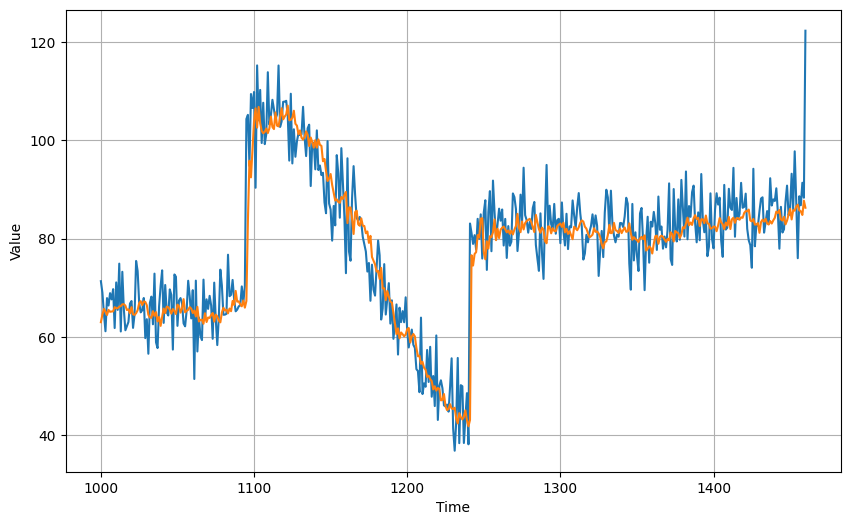

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [19]:
keras.metrics.mae(x_valid, cnn_forecast).numpy()

np.float32(4.640508)